*This notebook was created by Svitozar Serkez. Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). August 2019.*

## Tutorial N14: SASE estimation and imitation (unfinished)

In [13]:
import numpy as np
import logging

import ocelot
from ocelot import *
from ocelot.cpbd.beam import *
from ocelot.rad.fel_estimator import *
from ocelot.gui.beam_plot import *
from ocelot.gui.dfl_plot import *

ocelog.setLevel(logging.ERROR)
#ocelog.setLevel(logging.DEBUG)
#ocelog.setLevel(logging.INFO)

%matplotlib notebook

## Contents
1. [SASE estimator](#estimator)
2. [SASE imitator](#imitator)

## SASE estimator
Knowing the electron beam parameters and the magnetic lattice one can estimate  

<IPython.core.display.Javascript object>


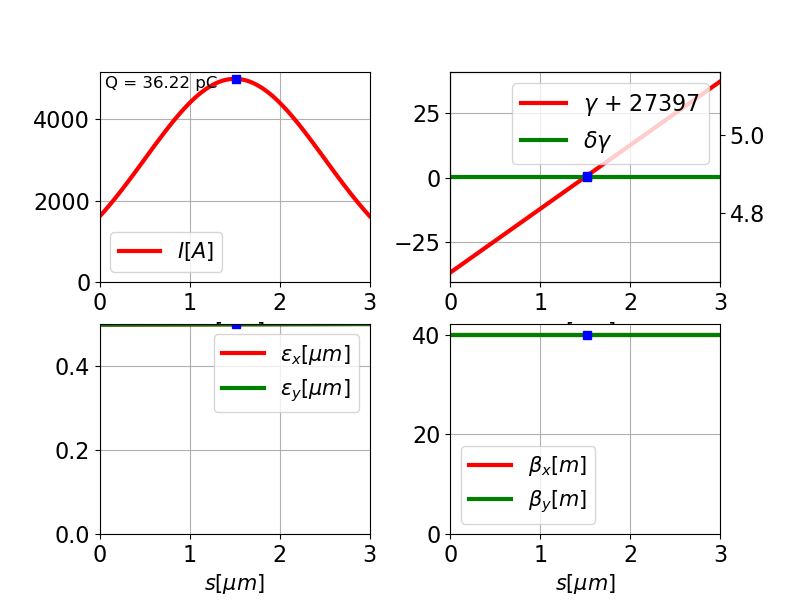

In [19]:
beam = generate_beam(E=14.0, dE=2.5e-3, I=5000, l_beam=1e-6, emit_n=0.5e-6, beta=40, l_window=3e-6, shape='gaussian', chirp=0.0009)
plot_beam(beam, figsize=2)

In [20]:
lat_pkg = create_exfel_lattice('sase1')
E_photon=8000
beta_av=20
prepare_el_optics(beam, lat_pkg, E_photon, beta_av, s=None)
lat = lat_pkg[0]
#plot_opt_func(lat, tws, top_plot=["mux", "muy"], legend=False)
#plt.show()

In [37]:
beta_av = 30
E_photon = 8000

#fel = beamlat2fel(beam, lat) #faster, propagates the beam through magnettic lattice to estimate average beta of poorly matched slices
fel = beam2fel(beam, lu=0.04, K_peak=3, iwityp=0)

zsat = 56.60
E_pulse_sat = 184.41 uJ


<IPython.core.display.Javascript object>


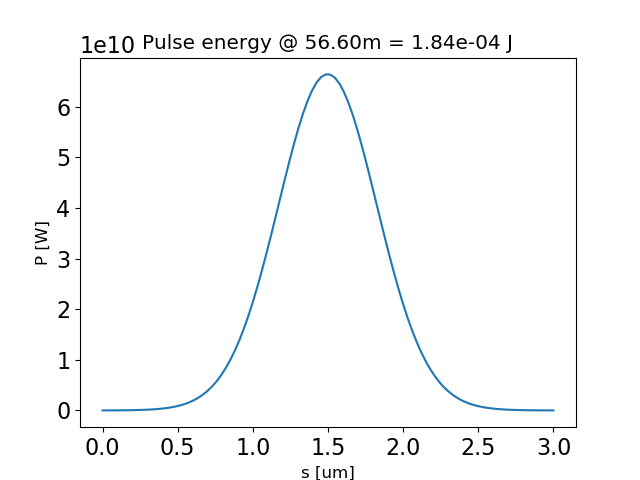

<IPython.core.display.Javascript object>


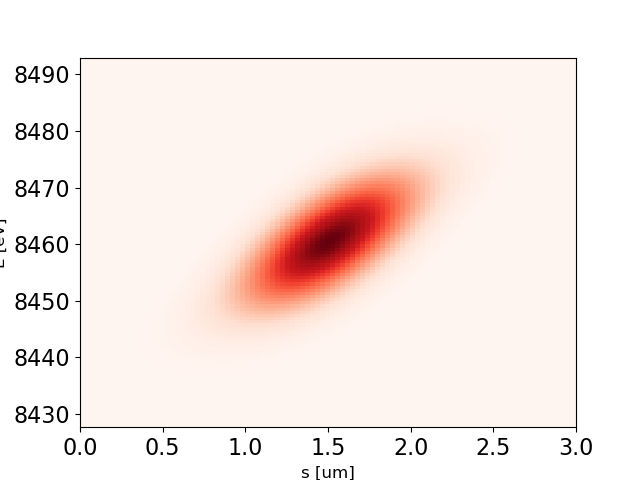

<IPython.core.display.Javascript object>


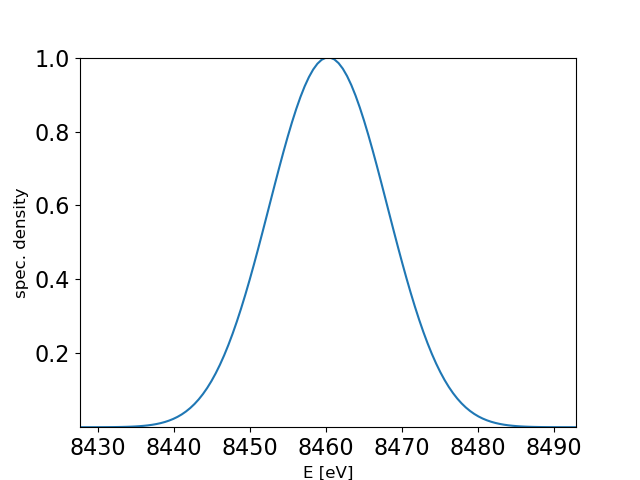

<IPython.core.display.Javascript object>


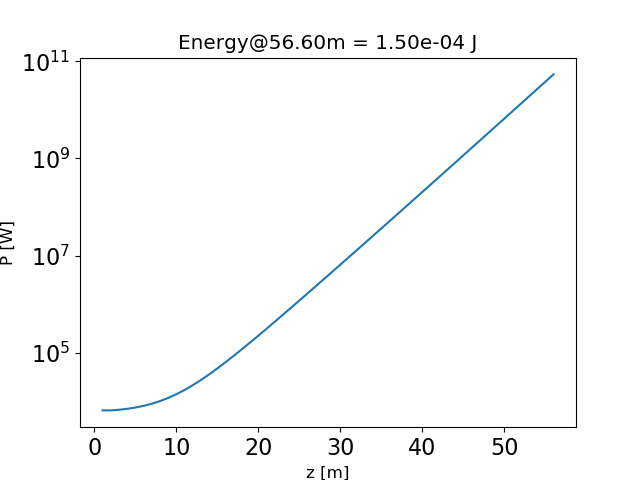

<IPython.core.display.Javascript object>


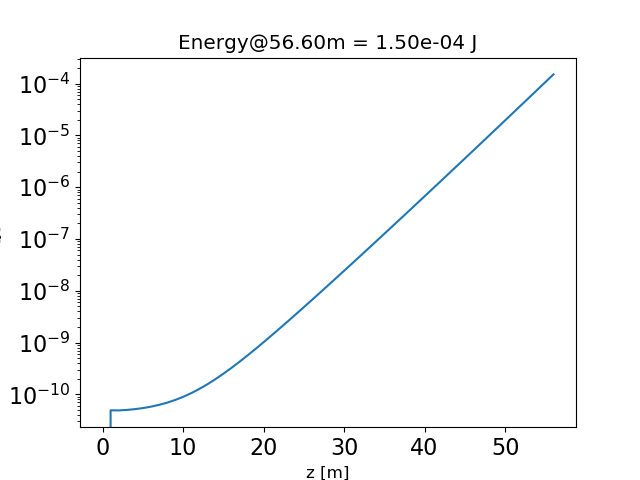

In [38]:
print('zsat = {:.2f}'.format(fel.z_sat_min))
print('E_pulse_sat = {:.2f} uJ'.format(fel.E() * 1e6))

#fel.log('print')
plot_estimator_power_z(fel)
plot_estimator_spectrogram(fel)
plot_estimator_spectrum(fel)
plot_estimator_power_evo(fel)
plot_estimator_energy_evo(fel)

<a id='imitate_sase_dfl'></a>
## SASE imitator

In [39]:
help(imitate_sase_dfl)

E_pohoton = 8000 #central photon energy [eV]
kwargs={'xlamds':(h_eV_s * speed_of_light / E_pohoton), #[m] - central wavelength
        'shape':(101,101,300),           #(x,y,z) shape of field matrix (reversed) to dfl.fld
        'dgrid':(200e-6,200e-6,15e-6), #(x,y,z) [m] - size of field matrix
        'power_rms':(3e-6,10e-6,2e-6),#(x,y,z) [m] - rms size of the radiation distribution (gaussian)
        'power_center':(0,0,None),     #(x,y,z) [m] - position of the radiation distribution
        'power_angle':(0,0),           #(x,y) [rad] - angle of further radiation propagation
        'power_waistpos':(-5,-15),     #(Z_x,Z_y) [m] downstrean location of the waist of the beam
        'wavelength':None,             #central frequency of the radiation, if different from xlamds
        'zsep':None,                   #distance between slices in z as zsep*xlamds
        'freq_chirp':0,                #dw/dt=[1/fs**2] - requency chirp of the beam around power_center[2]
        'en_pulse':1e-6,               #total energy or max power of the pulse, use only one
        'power':None,
        'rho':1e-4
        }
dfl = imitate_sase_dfl(**kwargs);

Help on function imitate_sase_dfl in module ocelot.optics.wave:

imitate_sase_dfl(xlamds, rho=0.0002, seed=None, **kwargs)
    imitation of SASE radiation in 3D
    
    xlamds - wavelength of the substracted fast-varying component
    rho - half of the expected FEL bandwidth
    **kwargs identical to generate_dfl()
    
    returns RadiationField object



<IPython.core.display.Javascript object>


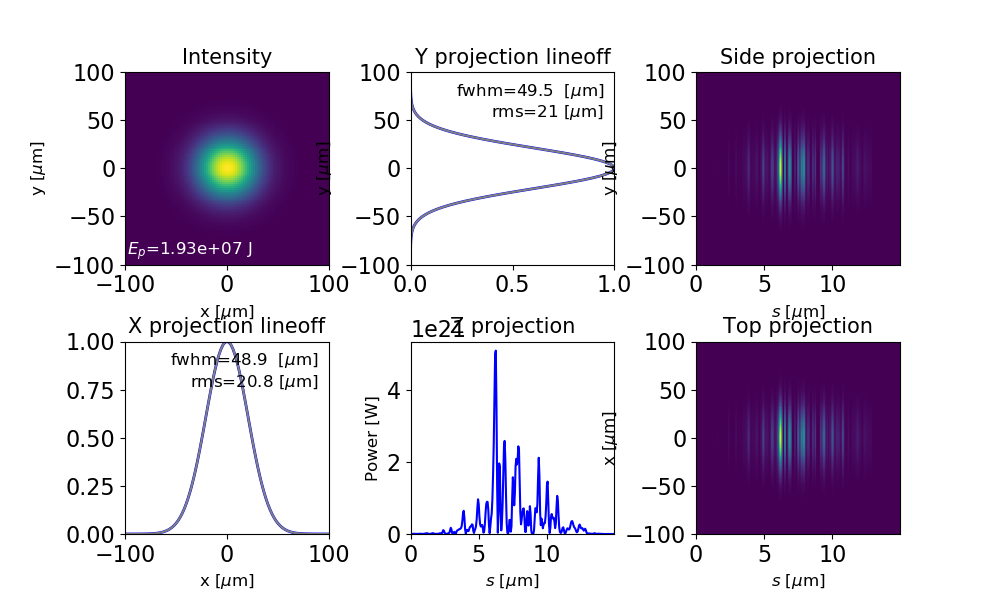

<IPython.core.display.Javascript object>


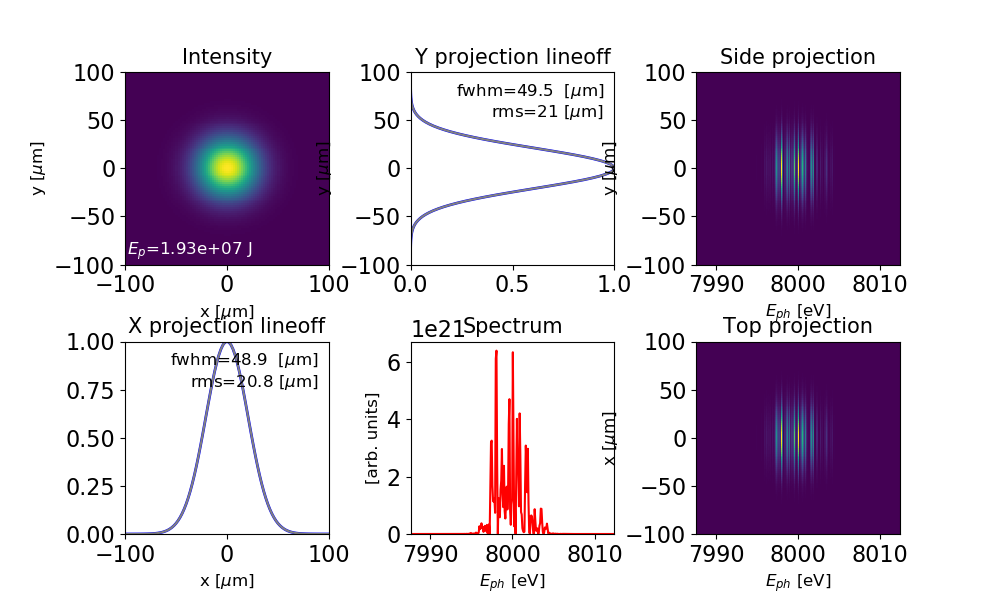

In [42]:
plot_dfl(dfl, domains = 'st', figsize=2)
plot_dfl(dfl, domains = 'sf', figsize=2)